In [55]:
import os
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'stixgeneral'
rcParams['text.usetex'] = False
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16

import vplanet_inference as vpi

In [56]:
import vplanet 
import alabi

### Set up input and output file directories

`vplanet_inference` requires that we have a set of template infiles saved somewhere. We will call the directory containing the infiles the `inpath`.

It also requires that we specify an `outpath` directory where infiles will be copied from `inpath` and written with the substituted parameters that we specify.

In [57]:
# Specify the directory to read infile templates from
inpath = os.path.join(vpi.INFILE_DIR, "/home/jcruz001/research/vplanet_inference/infiles/stellar")


# Speficy the directory where infiles will be written to
outpath = "output/"

#### astropy units

`vplanet_inference` makes use of a package called `astropy` to specify and handle all unit conversions in its calculations.

You can check out the [astropy docs](https://docs.astropy.org/en/stable/units/index.html) for an in-depth explanation for how to use `astropy.units`, but some useful units we'll use here are:

| Unit | Symbol | astropy variable |
| --- | --- | --- |
| Solar mass | $M_\odot$ | `u.Msun` |
| Solar luminosity | $L_\odot$ | `u.Lsun` |
| Solar radius | $R_\odot$ | `u.Rsun` |
| year | yr | `u.yr` |
| no units |  | `u.dimensionless_unscaled` |

Units can manipulated and converted to other units, for example:

In [6]:
10 * u.m / u.s

<Quantity 10. m / s>

In [4]:
(1*u.Msun).to(u.kg)

<Quantity 1.98840987e+30 kg>

In [7]:
(5 * u.km / u.hr).to(u.m / u.s)

<Quantity 1.38888889 m / s>

#### Specify model Input parameters

We can choose which variables in the infiles that we want to vary by creating a dictionary called `inparams`. The dict keys follow the convention `<infile name>.<variable name>` and the dict values specify the units for the variables using `astropy.units`.

In [58]:
# Dictionary of input parameters and units
inparams = {"star.dMass": u.Msun,
            "vpl.dStopTime": u.Gyr}

#### Specify model Output parameters

Similarly we can also create a dictionary called `outparams` which tells `vplanet_inference` which variables to add to our `saOutputOrder` for each body. The dict keys follow the convention `final.<body name>.<variable name>`, and the dict values use `astropy.units`.  

In [59]:
# Dictionary of output parameters and units
outparams = {"final.star.Radius": u.Rsun,
             "final.star.Luminosity": u.Lsun}

#### Initialize the vplanet model

Once we've specified our input and output variables (`inparams` and `outparams`), and the directories where input and output files will be read/written (`inpath` and `outpath`), we can initialize a `VplanetModel`. 

In addition, we can also specify the `time_init` (the initial time at which the simulation starts) and the `timesteps` (how frequently the outputs will be spaced). So if we set `time_init=5e6*u.yr` and `timesteps=1e6*u.yr` this will give us output times spaced like: [5e6, 6e6, 7e6, ..., 8.999e9, 9e9]

Setting `verbose = True` will tell the model to print out progress info when we run the model.

In [60]:
vpm = vpi.VplanetModel(inparams=inparams,
                       outparams=outparams,
                       inpath="/home/jcruz001/research/vplanet_inference/infiles/stellar",
                       outpath="/home/jcruz001/research/yupra/JCruz001/tutorials/output",
                       time_init=5e6*u.yr,
                       timesteps=1e6*u.yr,
                       verbose=True)

#### Example: evolution of the sun

As an example, we'll compute the evolution of a sun-like star.

We'll define a variable called `theta`, which will be our array of values that we substitute in for the inparameters. These values should be the same order and units that we specified in our `inparams` dictionary. For this example, we'll set `star.dMass` to `1.0` solar masses, and `vpl.dStopTime` (the final age of the system) to `9.0` gigayears.

We can also optionally choose to save the written infiles to a specified `outsubpath` if we wish to inspect those later, such as for debugging. (If you run many simulations though, it is often better to say `remove=True` which deletes the infiles after the results are read. This will save you disk space.)

In [61]:
# Run the vplanet model
theta = np.array([1.0, 9.0])
evol = vpm.run_model(theta, remove=False, outsubpath="solar_evol")


Input:
-----------------
star.dMass : 1.0 [solMass] (user)   --->   1.988409870698051e+30 [kg] (vpl file)
vpl.dStopTime : 9.0 [Gyr] (user)   --->   2.840184e+17 [s] (vpl file)

Created file /home/jcruz001/research/yupra/JCruz001/tutorials/output/solar_evol/vpl.in
Created file /home/jcruz001/research/yupra/JCruz001/tutorials/output/solar_evol/star.in
Executed model /home/jcruz001/research/yupra/JCruz001/tutorials/output/solar_evol/vpl.in 46.960 s

Output:
-----------------
final.star.Luminosity : 1.46994644723093 [solLum]
final.star.Radius : 1.2128696277130946 [solRad]



The results of our evolution model are saved to a variable called `evol`. If you print the results, you'll see that `evol` is a dictionary, where the keys are the variables we specified in our `outparams` dictionary, and the values of the dictionary are arrays containing value of each variable at each timestep with the units we specified.

In [62]:
evol

{'final.star.Luminosity': <VPLANETQuantity [0.64096578, 0.57682419, 0.53206505, ..., 1.46994645,
                   1.46994645, 1.46994645] solLum>,
 'final.star.Radius': <VPLANETQuantity [1.43389392, 1.36010004, 1.3032261 , ..., 1.21286963,
                   1.21286963, 1.21286963] solRad>,
 'Time': <VPLANETQuantity [0.00000000e+00, 1.00000000e+06, 2.00000000e+06, ...,
                   8.99800048e+09, 8.99899866e+09, 9.00000000e+09] yr>}

#### Plotting the evolution

We can plot the results showing the stars luminosity evolution vs. time:

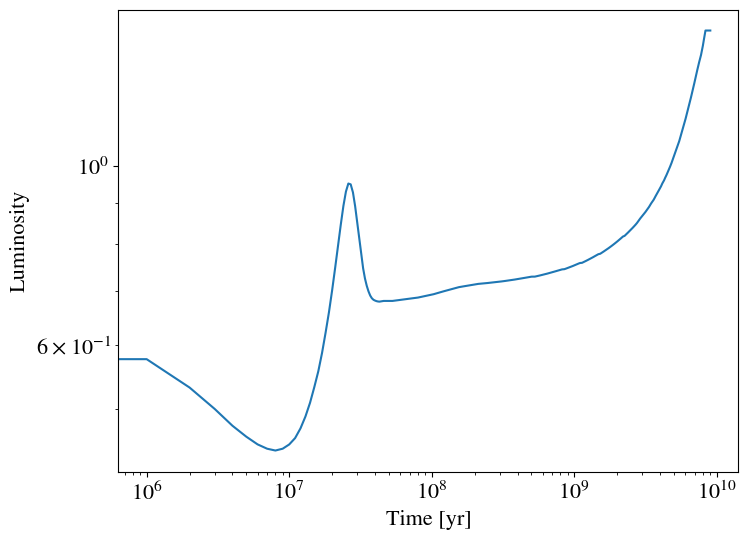

In [63]:
plt.figure(figsize=[8,6])
plt.plot(evol["Time"], evol["final.star.Luminosity"])
plt.xlabel("Time [yr]")
plt.ylabel("Luminosity")
plt.xscale("log")
plt.yscale("log")
plt.show()

#### Task: plot the evolution of the star's radius

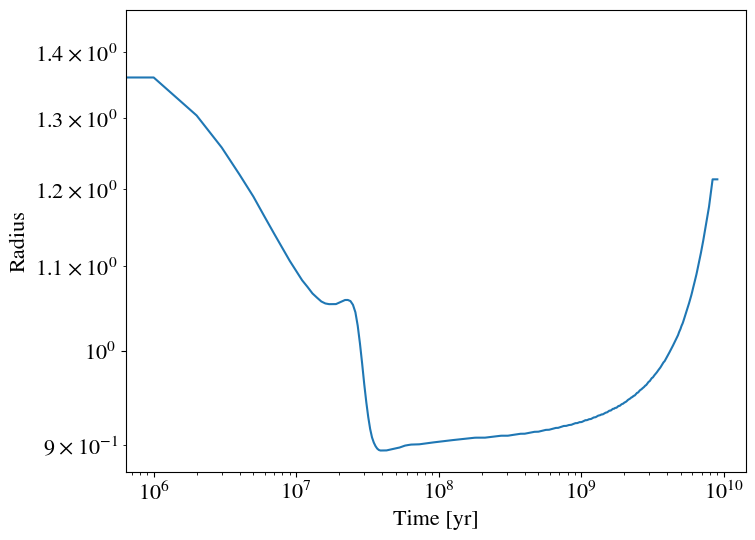

In [64]:
#[your code goes here...]
plt.figure(figsize=[8,6])
plt.plot(evol["Time"], evol["final.star.Radius"])
plt.xlabel("Time [yr]")
plt.ylabel("Radius")
plt.xscale("log")
plt.yscale("log")
plt.show()

### Options for output variables

Take a look at the files that the model has created in `outpath` directory. Within the local directory of this notebook, you should see a list of files like:
```bash
output/
    solar_evol/
        star.in
        system.log
        system.star.forward
        vpl.in
```

Now see what output parameters you can add to `outparams`. For a description of available output options for each `vplanet` model, see the [documentation here](https://virtualplanetarylaboratory.github.io/vplanet/help.html). You can also open up the log file for one of the simulations we've run, which should show a list of variables like this. For example, the file `infile_templates/solar_evol/system.log` should contain a list that looks something like this:

<details open>

  <summary>system.log</summary>

  ```
-------- Log file system.log -------

Executable: /home/jbirky/.conda/envs/py39/bin/vplanet
Version: Unknown
System Name: system
Primary Input File: vpl.in
Body File #1: star.in
Allow files to be overwitten: Yes
Mass Units: Grams
Length Units: Meters
Time Units: Seconds
Angle Units: Radians

------- FORMATTING -----
Verbosity Level: 0
Crossover Decade for Scientific Notation: 4
Number of Digits After Decimal: 6
Integration Method: Runge-Kutta4
Direction: Forward
Time Step: 3.155760e+07
Stop Time: 2.840184e+17
Output Interval: 3.155760e+13
Use Variable Timestep: Yes
dEta: 0.010000
Minimum Value of ecc and obl: 1.000000e-10


---- INITIAL SYSTEM PROPERTIES ----
(Age) System Age [sec]: 1.577880e+14 
(Time) Simulation Time [sec]: 0.000000 
(TotAngMom) Total Angular Momentum [kg*m^2/sec]: 2.904811e+43 
(TotEnergy) Total System Energy [kg*m^2/sec^2]: -1.576626e+41 
(PotEnergy) Body's non-orbital Potential Energy [kg*m^2/sec^2]: -1.587188e+41 
(KinEnergy) Body's non-orbital Kinetic Energy [kg*m^2/sec^2]: 1.056219e+39 
(DeltaTime) Average Timestep Over Last Output Interval [sec]: 0.000000 

----- BODY: star ----
Active Modules: STELLAR
Module Bit Sum: 65
Color: 000000
(Mass) Mass [kg]: 1.988410e+30 
(Radius) Radius [m]: 9.975600e+08 
(RadGyra) Radius of Gyration/Moment of Inertia Constant []: 0.449297 
(RotAngMom) Rotational Angular Momentum [kg*m^2/sec]: 2.904811e+43 
(RotVel) Rotational Velocity [m/sec]: 7.254461e+04 
(BodyType) Type of Body (0 == planet) []: 0.000000 
(RotRate) Rotational Frequency [/sec]: 7.272205e-05 
(RotPer) Rotational Period [sec]: 8.640000e+04 
(Density) Average Density [kg/m^3]: 478.189663 
(HZLimitDryRunaway) Semi-major axis of Dry Runaway HZ Limit [m]: 1.084537e+11 
(HZLimRecVenus) Recent Venus HZ Limit [m]: 9.447390e+10 
(HZLimRunaway) Runaway Greenhouse HZ Limit [m]: 1.254258e+11 
(HZLimMoistGreenhouse) Moist Greenhouse HZ Limit [m]: 1.250040e+11 
(HZLimMaxGreenhouse) Maximum Greenhouse HZ Limit [m]: 2.269291e+11 
(HZLimEarlyMars) Early Mars HZ Limit [m]: 2.475328e+11 
(Instellation) Orbit-averaged INcident STELLar radiATION [kg*m^2/sec^2/(m^2*sec)]: -1.000000 
(CriticalSemiMajorAxis) Holman & Wiegert (1999) P-type Critical Semi-major Axis [m]: -1.000000 
(LXUVTot) Total XUV Luminosity [kg*m^2/sec^2/(m^2*sec)]: 2.453617e+23 
(LostEnergy) Body's Total Lost Energy [kg*m^2/sec^2]: 5.562685e-309 
(LostAngMom) Lost Angular Momentum due to Magnetic Braking [kg*m^2/sec]: 5.562685e-309 
----- STELLAR PARAMETERS (star)------
(Luminosity) Luminosity [kg*m^2/sec^3]: 2.453617e+26 
(LXUVStellar) Base X-ray/XUV Luminosity [kg*m^2/sec^3]: 2.453617e+23 
(Temperature) Effective Temperature [K]: 4309.976981 
(LXUVFrac) Fraction of luminosity in XUV []: 0.001000 
(RossbyNumber) Rossby Number []: 0.028968 
(DRotPerDtStellar) Time Rate of Change of Rotation Period in STELLAR []: -3.381378e-10 
Output Order: Time[sec] Luminosity[kg*m^2/sec^3] Radius[m]
Grid Output Order:



---- FINAL SYSTEM PROPERTIES ----
(Age) System Age [sec]: 2.841762e+17 
(Time) Simulation Time [sec]: 2.840184e+17 
(TotAngMom) Total Angular Momentum [kg*m^2/sec]: 2.905763e+43 
(TotEnergy) Total System Energy [kg*m^2/sec^2]: -1.576418e+41 
(PotEnergy) Body's non-orbital Potential Energy [kg*m^2/sec^2]: -1.876426e+41 
(KinEnergy) Body's non-orbital Kinetic Energy [kg*m^2/sec^2]: 9.262456e+34 
(DeltaTime) Average Timestep Over Last Output Interval [sec]: 8.546382e+07 

----- BODY: star ----
Active Modules: STELLAR
Module Bit Sum: 65
Color: 000000
(Mass) Mass [kg]: 1.988410e+30 
(Radius) Radius [m]: 8.437934e+08 
(RadGyra) Radius of Gyration/Moment of Inertia Constant []: 0.237427 
(RotAngMom) Rotational Angular Momentum [kg*m^2/sec]: 1.215901e+41 
(RotVel) Rotational Velocity [m/sec]: 1285.565269 
(BodyType) Type of Body (0 == planet) []: 0.000000 
(RotRate) Rotational Frequency [/sec]: 1.523555e-06 
(RotPer) Rotational Period [sec]: 4.124030e+06 
(Density) Average Density [kg/m^3]: 790.148950 
(HZLimitDryRunaway) Semi-major axis of Dry Runaway HZ Limit [m]: 1.642395e+11 
(HZLimRecVenus) Recent Venus HZ Limit [m]: 1.354015e+11 
(HZLimRunaway) Runaway Greenhouse HZ Limit [m]: 1.768472e+11 
(HZLimMoistGreenhouse) Moist Greenhouse HZ Limit [m]: 1.791572e+11 
(HZLimMaxGreenhouse) Maximum Greenhouse HZ Limit [m]: 3.038232e+11 
(HZLimEarlyMars) Early Mars HZ Limit [m]: 3.314952e+11 
(Instellation) Orbit-averaged INcident STELLar radiATION [kg*m^2/sec^2/(m^2*sec)]: -1.000000 
(CriticalSemiMajorAxis) Holman & Wiegert (1999) P-type Critical Semi-major Axis [m]: -1.000000 
(LXUVTot) Total XUV Luminosity [kg*m^2/sec^2/(m^2*sec)]: 3.769280e+22 
(LostEnergy) Body's Total Lost Energy [kg*m^2/sec^2]: 3.000065e+40 
(LostAngMom) Lost Angular Momentum due to Magnetic Braking [kg*m^2/sec]: 2.893603e+43 
----- STELLAR PARAMETERS (star)------
(Luminosity) Luminosity [kg*m^2/sec^3]: 5.626955e+26 
(LXUVStellar) Base X-ray/XUV Luminosity [kg*m^2/sec^3]: 3.769280e+22 
(Temperature) Effective Temperature [K]: 5767.189213 
(LXUVFrac) Fraction of luminosity in XUV []: 6.698615e-05 
(RossbyNumber) Rossby Number []: 3.685018 
(DRotPerDtStellar) Time Rate of Change of Rotation Period in STELLAR []: 7.878728e-12 
Output Order: Time[sec] Luminosity[kg*m^2/sec^3] Radius[m]
Grid Output Order:
```

</details>

Parameters listed in parenthesis can be added to the `outparams` dictionary.

### Adding XUV luminosity as an output parameter

Say we also want to model the XUV luminosity of our star.

`vplanet` includes the Ribas+2005 empirical model for XUV evolution of low-mass, which is parameterized by a broken power law:
\begin{align}
\frac{L_{\rm XUV}}{L_{\rm bol}} = \left\{
				\begin{array}{lcr}
					f_\mathrm{sat} &\ & t \leq t_\mathrm{sat} \\
					f_\mathrm{sat}\left(\frac{t}{t_\mathrm{sat}}\right)^{-\beta_\mathrm{XUV}} &\ & t > t_\mathrm{sat}
				\end{array}
				\right.
\end{align}
This model assumes that young (more active) stars exhibit a "saturated" level of XUV luminosity relative to bolometric (total luminosity), which then decays exponentially over time, after a "saturation time". Here $L_{\rm bol}$ is the bolometric luminosity [$L_\odot$], $L_{\rm XUV}$ is the XUV luminosity [$L_\odot$], $f_\mathrm{sat} = \log_{10}(L_{\rm XUV}/L_{\rm bol})$ is the saturation ratio, $t_\mathrm{sat}$ is the duration of saturation phase [Gyr], $\beta_\mathrm{XUV}$ is the exponential decay rate of $L_{\rm XUV}$ after saturation, and $t$ is the evolution time [Gyr].

To have `vplanet` compute the XUV lumiosity evolution using this model, we'll add the following input variables to our body infiles (since they are properties of the star, they will go in `star.in`):
```
dSatXUVFrac            
dSatXUVTime              
dXUVBeta   
```
And we will also add the following variable to our output variables in `saOutputOrder`:
```
LXUVTot
```

In [70]:
inparams  = {"star.dMass": u.Msun,          
             "star.dSatXUVFrac": u.dex(u.dimensionless_unscaled),   
             "star.dSatXUVTime": u.Gyr,    
             "vpl.dStopTime": u.Gyr,       
             "star.dXUVBeta": -u.dimensionless_unscaled}

outparams = {"final.star.Radius": u.Rsun,
             "final.star.Luminosity": u.Lsun,
             "final.star.LXUVStellar": u.Lsun,}

vpm = vpi.VplanetModel(inparams=inparams,
                       outparams=outparams,
                       inpath="/home/jcruz001/research/vplanet_inference/infiles/stellar",
                       outpath="/home/jcruz001/research/yupra/JCruz001/tutorials",
                       time_init=5e6*u.yr,
                       timesteps=1e6*u.yr,
                       verbose=True)

#### Example: evolution of Trappist-1

Make modifications to the template above by subsituting different input parameter values, then execute and plot your results. Try using the parameters from [Birky et al. 2021](https://arxiv.org/abs/2105.12562) for the Trappist-1 exoplanet hosting system.

In [1]:
inparams  = {"star.dMass": u.Msun,          
             "star.dSatXUVFrac": u.dex(u.dimensionless_unscaled),   
             "star.dSatXUVTime": u.Gyr,    
             "vpl.dStopTime": u.Gyr,       
             "star.dXUVBeta": -u.dimensionless_unscaled}

outparams = {"final.star.Radius": u.Rsun,
             "final.star.Luminosity": u.Lsun,
             "final.star.LXUVStellar": u.Lsun,
             "initial.star.LXUVTot": u.Lsun,
             "final.star.LXUVTot": u.Lsun}

vpm = vpi.VplanetModel(inparams=inparams,
                       outparams=outparams,
                       inpath="/home/jcruz001/research/vplanet_inference/infiles/stellar",
                       outpath="/home/jcruz001/research/yupra/JCruz001/tutorials/output",
                       time_init=5e6*u.yr,
                       timesteps=1e6*u.yr,
                       verbose=True)

NameError: name 'u' is not defined

In [95]:
Omega = np.array([0.09,-3.03,3.14, 7.96, -1.17])
evol = vpm.run_model(Omega, remove=False, outsubpath="solar_evol_trappist")


Input:
-----------------
star.dMass : 0.09 [solMass] (user)   --->   1.789568883628246e+29 [kg] (vpl file)
star.dSatXUVFrac : -3.03 [dex] (user)   --->   0.0009332543007969915 [] (vpl file)
star.dSatXUVTime : 3.14 [Gyr] (user)   --->   9.9090864e+16 [s] (vpl file)
vpl.dStopTime : 7.96 [Gyr] (user)   --->   2.51198496e+17 [s] (vpl file)
star.dXUVBeta : -1.17 [-1.0] (user)   --->   1.17 [] (vpl file)

Created file /home/jcruz001/research/yupra/JCruz001/tutorials/output/solar_evol_trappist/vpl.in
Created file /home/jcruz001/research/yupra/JCruz001/tutorials/output/solar_evol_trappist/star.in
Executed model /home/jcruz001/research/yupra/JCruz001/tutorials/output/solar_evol_trappist/vpl.in 13.703 s
Failed to convert parameter star LXUVTot to unit solLum
star LXUVTot array: [8.297553e+21 6.953263e+21 6.042797e+21 ... 6.748603e+19 6.747611e+19
 6.746620e+19]

Output:
-----------------
final.star.LXUVStellar : 1.7621810344827586e-07 [solLum]
final.star.LXUVTot : nan [solLum]
final.star.Lumino

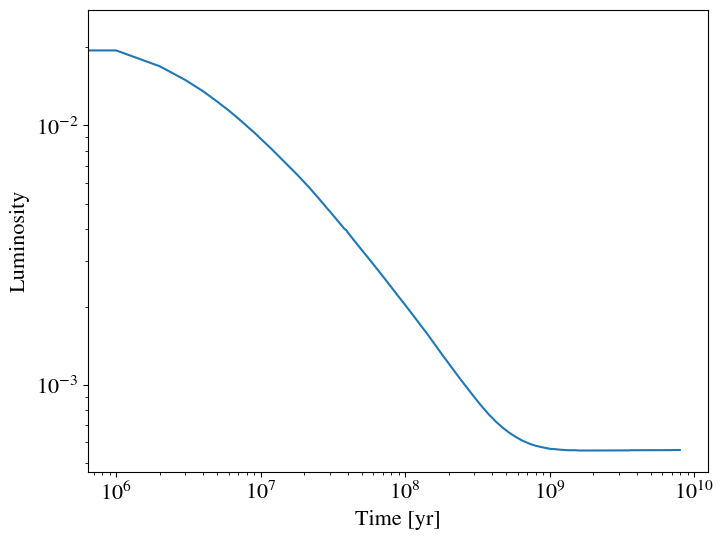

In [67]:
plt.figure(figsize=[8,6])
plt.plot(evol["Time"], evol["final.star.Luminosity"])
plt.xlabel("Time [yr]")
plt.ylabel("Luminosity")
plt.xscale("log")
plt.yscale("log")
plt.show()

#### Habitable zone limits

How does the "habitable zone" vary for Trappist-1? See what this looks like for different planetary conditions from [Kopparapu+2013](https://iopscience.iop.org/article/10.1088/0004-637X/765/2/131/meta) by adding these variables to your `outparams` dictionary and re-running the model:
```
HZLimitDryRunaway
HZLimRecVenus
HZLimRunaway
HZLimMoistGreenhouse
HZLimMaxGreenhouse
HZLimEarlyMars  
```

In [96]:
#[your code goes here...]
inparams  = {"star.dMass": u.Msun,          
             "star.dSatXUVFrac": u.dex(u.dimensionless_unscaled),   
             "star.dSatXUVTime": u.Gyr,    
             "vpl.dStopTime": u.Gyr,       
             "star.dXUVBeta": -u.dimensionless_unscaled}

outparams = {"final.star.Radius": u.Rsun,
             "final.star.Luminosity": u.Lsun,
             "final.star.LXUVStellar": u.Lsun,
             "final.star.HZLimitDryRunaway": u.m,
             "final.star.HZLimRecVenus": u.m,
             "final.star.HZLimRunaway": u.m,
             "final.star.HZLimMoistGreenhouse": u.m,
             "final.star.HZLimMaxGreenhouse": u.m,
             "final.star.HZLimEarlyMars": u.m }

vpm = vpi.VplanetModel(inparams=inparams,
                       outparams=outparams,
                       inpath="/home/jcruz001/research/vplanet_inference/infiles/stellar",
                       outpath="/home/jcruz001/research/yupra/JCruz001/tutorials/output",
                       time_init=5e6*u.yr,
                       timesteps=1e6*u.yr,
                       verbose=True)

In [97]:
Ohm = np.array([0.09,-3.03,3.14, 7.96, -1.17])
evol = vpm.run_model(Ohm, remove=False, outsubpath="solar_evol_trappist")


Input:
-----------------
star.dMass : 0.09 [solMass] (user)   --->   1.789568883628246e+29 [kg] (vpl file)
star.dSatXUVFrac : -3.03 [dex] (user)   --->   0.0009332543007969915 [] (vpl file)
star.dSatXUVTime : 3.14 [Gyr] (user)   --->   9.9090864e+16 [s] (vpl file)
vpl.dStopTime : 7.96 [Gyr] (user)   --->   2.51198496e+17 [s] (vpl file)
star.dXUVBeta : -1.17 [-1.0] (user)   --->   1.17 [] (vpl file)

Created file /home/jcruz001/research/yupra/JCruz001/tutorials/output/solar_evol_trappist/vpl.in
Created file /home/jcruz001/research/yupra/JCruz001/tutorials/output/solar_evol_trappist/star.in
Executed model /home/jcruz001/research/yupra/JCruz001/tutorials/output/solar_evol_trappist/vpl.in 14.504 s

Output:
-----------------
final.star.HZLimEarlyMars : 8132915000.0 [m]
final.star.HZLimMaxGreenhouse : 7457054000.0 [m]
final.star.HZLimMoistGreenhouse : 3840292000.0 [m]
final.star.HZLimRecVenus : 2902347000.0 [m]
final.star.HZLimRunaway : 3813302000.0 [m]
final.star.HZLimitDryRunaway : 320879